In [80]:
import numpy as np
import pandas as pd 
from sklearn import linear_model, model_selection
import imblearn
from imblearn import over_sampling
import scipy
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('./data/rankingcard.csv', index_col=0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data.shape

(150000, 11)

In [4]:
# NumberOfDependents 缺失大约3%的数据
# MonthlyIncome 缺失20%的数据
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [5]:
146076/ 150000.0

0.97384

In [6]:
# 去除重复数据
data.drop_duplicates(inplace=True)

In [7]:
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [8]:
# 查看缺失值
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [9]:
# NumberOfDependents 不包括自己的家属总数
data['NumberOfDependents'].fillna(int(data['NumberOfDependents'].mean()), inplace=True)

In [10]:
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000000
dtype: float64

In [30]:
# 对于MonthlyIncome 我们使用随机森林回归来填充值
def fill_missing_rf(X, y, to_fill):
    """
    使用随机森林填补一个特征缺失值
    X: 要填补的特征矩阵
    y: 完整的，没有缺失值的标签
    to_fill: 字符串，要填补的那一列的名称
    """
    
    df = X.copy()
    fill = df.loc[:, to_fill]
    
    # 构建新的特征矩阵
    df = pd.concat([df.loc[:, df.columns != to_fill], pd.DataFrame(y)], axis=1)
    
    # 找出训练集和测试集
    y_train = fill[fill.notnull()]
    y_test = fill[fill.isnull()]
    
    x_train = df.iloc[y_train.index, :]
    x_test = df.iloc[y_test.index, :]
    
    # 建立随机森林回归模型 来填补缺失值
    from sklearn import ensemble
    
    rfr = ensemble.RandomForestRegressor(n_estimators=100).fit(x_train, y_train)
    y_pred = rfr.predict(x_test)
    
    return y_pred
    

In [31]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
y.shape

(149391,)

In [32]:
# 使用上面封装的函数进行填充缺失值
y_pred = fill_missing_rf(X, y, 'MonthlyIncome')
data.loc[data.loc[:, 'MonthlyIncome'].isnull(), 'MonthlyIncome'] = y_pred

In [33]:
data.isnull().mean()

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

In [34]:
# 描述性统计处理异常值
data.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5425.894453,13259.218168,0.0,0.0,0.180000,1800.000000,4419.000000,7416.000000,10800.000000,23250.600000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [36]:
# 年龄最小值为0，这不符合银行的业务需求，即使是儿童账户也要至少8岁
(data['age'] == 0).sum()

1

In [39]:
data = data[data['age'] != 0]

In [41]:
# 另外还有三个指标不正常 
# NumberOfTime30-59DaysPastDueNotWorse 
# NumberOfTimes90DaysLate
# NumberOfTime60-89DaysPastDueNotWorse

data[data['NumberOfTime30-59DaysPastDueNotWorse'] > 90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [42]:
# 剔除大于90的数据
data = data[data['NumberOfTime30-59DaysPastDueNotWorse'] < 90]

In [43]:
data[data['NumberOfTimes90DaysLate'] > 90].count()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [44]:
data[data['NumberOfTime60-89DaysPastDueNotWorse'] > 90].count()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [45]:
# 恢复索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
SeriousDlqin2yrs                        149165 non-null int64
RevolvingUtilizationOfUnsecuredLines    149165 non-null float64
age                                     149165 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149165 non-null int64
DebtRatio                               149165 non-null float64
MonthlyIncome                           149165 non-null float64
NumberOfOpenCreditLinesAndLoans         149165 non-null int64
NumberOfTimes90DaysLate                 149165 non-null int64
NumberRealEstateLoansOrLines            149165 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149165 non-null int64
NumberOfDependents                      149165 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [46]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
y.value_counts()

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

In [48]:
# 样本不均衡问题 上采样 下采样
sm = over_sampling.SMOTE(random_state=66)
X, y = sm.fit_sample(X, y)
pd.Series(y).value_counts()

1    139292
0    139292
dtype: int64

In [50]:
# 然后划分训练集和测试集
X = pd.DataFrame(X)
y = pd.DataFrame(y)
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=66)


In [51]:
x_train.shape

(195008, 10)

In [52]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9
33594,0.049337,53.000000,0.000000,805.000000,0.490000,12.000000,0.0,1.000000,0.00000,0.000000
194031,0.491558,44.543111,1.000000,0.327845,6045.913777,4.514370,0.0,1.514370,0.51437,1.456889
129142,0.005643,69.000000,0.000000,0.315537,5000.000000,9.000000,0.0,1.000000,0.00000,1.000000
233862,0.475414,32.620861,1.137418,0.779157,3800.000000,9.758279,0.0,1.758279,0.00000,1.516558
96721,0.257248,43.000000,0.000000,0.626258,10731.000000,7.000000,0.0,4.000000,0.00000,4.000000


In [53]:
# 训练集
train_data = pd.concat([y_train, x_train], axis=1)
train_data.index = range(train_data.shape[0])
train_data.columns = data.columns

In [54]:
# 测试集
test_data = pd.concat([y_test, x_test], axis=1)
test_data.index = range(test_data.shape[0])
test_data.columns = data.columns

In [55]:
# 暂存数据
train_data.to_csv('./temp/train_data.csv', index=False)
test_data.to_csv('./temp/test_data.csv', index=False)

In [57]:
# 分箱
train_data['qcut'], updown = pd.qcut(train_data['age'], retbins=True, q=20)

In [60]:
updown

array([ 21.        ,  28.        ,  31.16507784,  34.        ,
        36.78613779,  39.        ,  41.        ,  43.        ,
        45.        ,  47.        ,  48.50354335,  50.00248948,
        52.        ,  54.        ,  56.        ,  58.68737398,
        61.        ,  64.        ,  68.        ,  74.        ,
       107.        ])

In [63]:
# 统计每个分箱中0和1的数量
train_data[train_data['SeriousDlqin2yrs'] == 0].groupby('qcut').count()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
qcut,,,,,,,,,,,
"(20.999, 28.0]",4222,4222,4222,4222,4222,4222,4222,4222,4222,4222,4222
"(28.0, 31.165]",3497,3497,3497,3497,3497,3497,3497,3497,3497,3497,3497
"(31.165, 34.0]",3999,3999,3999,3999,3999,3999,3999,3999,3999,3999,3999
"(34.0, 36.786]",2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904
"(36.786, 39.0]",5156,5156,5156,5156,5156,5156,5156,5156,5156,5156,5156
"(39.0, 41.0]",3966,3966,3966,3966,3966,3966,3966,3966,3966,3966,3966
"(41.0, 43.0]",4029,4029,4029,4029,4029,4029,4029,4029,4029,4029,4029
"(43.0, 45.0]",4443,4443,4443,4443,4443,4443,4443,4443,4443,4443,4443
"(45.0, 47.0]",4769,4769,4769,4769,4769,4769,4769,4769,4769,4769,4769


In [64]:
train_data[train_data['SeriousDlqin2yrs'] == 0].groupby('qcut').count()['SeriousDlqin2yrs']

qcut
(20.999, 28.0]      4222
(28.0, 31.165]      3497
(31.165, 34.0]      3999
(34.0, 36.786]      2904
(36.786, 39.0]      5156
(39.0, 41.0]        3966
(41.0, 43.0]        4029
(43.0, 45.0]        4443
(45.0, 47.0]        4769
(47.0, 48.504]      2468
(48.504, 50.002]    4886
(50.002, 52.0]      4633
(52.0, 54.0]        4706
(54.0, 56.0]        4595
(56.0, 58.687]      4491
(58.687, 61.0]      6646
(61.0, 64.0]        7001
(64.0, 68.0]        6683
(68.0, 74.0]        6698
(74.0, 107.0]       7759
Name: SeriousDlqin2yrs, dtype: int64

In [65]:
# 统计每个分箱中0和1的数量
count_y0 = train_data[train_data['SeriousDlqin2yrs'] == 0].groupby('qcut').count()['SeriousDlqin2yrs']
count_y1 = train_data[train_data['SeriousDlqin2yrs'] == 1].groupby('qcut').count()['SeriousDlqin2yrs']


In [66]:
count_y0

qcut
(20.999, 28.0]      4222
(28.0, 31.165]      3497
(31.165, 34.0]      3999
(34.0, 36.786]      2904
(36.786, 39.0]      5156
(39.0, 41.0]        3966
(41.0, 43.0]        4029
(43.0, 45.0]        4443
(45.0, 47.0]        4769
(47.0, 48.504]      2468
(48.504, 50.002]    4886
(50.002, 52.0]      4633
(52.0, 54.0]        4706
(54.0, 56.0]        4595
(56.0, 58.687]      4491
(58.687, 61.0]      6646
(61.0, 64.0]        7001
(64.0, 68.0]        6683
(68.0, 74.0]        6698
(74.0, 107.0]       7759
Name: SeriousDlqin2yrs, dtype: int64

In [67]:
count_y1

qcut
(20.999, 28.0]      5943
(28.0, 31.165]      5839
(31.165, 34.0]      6520
(34.0, 36.786]      6078
(36.786, 39.0]      5662
(39.0, 41.0]        5567
(41.0, 43.0]        5831
(43.0, 45.0]        5662
(45.0, 47.0]        6440
(47.0, 48.504]      4509
(48.504, 50.002]    4864
(50.002, 52.0]      5979
(52.0, 54.0]        5346
(54.0, 56.0]        4466
(56.0, 58.687]      4786
(58.687, 61.0]      3969
(61.0, 64.0]        3745
(64.0, 68.0]        2627
(68.0, 74.0]        2113
(74.0, 107.0]       1511
Name: SeriousDlqin2yrs, dtype: int64

In [68]:
# 将数据合并 上届，下届，0出现的次数，1出现的次数
num_bins = [*zip(updown, updown[1:], count_y0, count_y1)]

In [69]:
num_bins

[(21.0, 28.0, 4222, 5943),
 (28.0, 31.165077844995317, 3497, 5839),
 (31.165077844995317, 34.0, 3999, 6520),
 (34.0, 36.786137785808776, 2904, 6078),
 (36.786137785808776, 39.0, 5156, 5662),
 (39.0, 41.0, 3966, 5567),
 (41.0, 43.0, 4029, 5831),
 (43.0, 45.0, 4443, 5662),
 (45.0, 47.0, 4769, 6440),
 (47.0, 48.503543347020816, 2468, 4509),
 (48.503543347020816, 50.0024894803051, 4886, 4864),
 (50.0024894803051, 52.0, 4633, 5979),
 (52.0, 54.0, 4706, 5346),
 (54.0, 56.0, 4595, 4466),
 (56.0, 58.6873739761368, 4491, 4786),
 (58.6873739761368, 61.0, 6646, 3969),
 (61.0, 64.0, 7001, 3745),
 (64.0, 68.0, 6683, 2627),
 (68.0, 74.0, 6698, 2113),
 (74.0, 107.0, 7759, 1511)]

In [72]:
# 确保每个箱中都包含0和1
# for i in range(len(num_bins)):
#     if 0 in num_bins[i, 2:]:
#         num_bins[i-1: i+1] = [(num_bins[i-1, 0],
#                                num_bins[i, 1],
#                                num_bins[i-1, 2] + num_bins[i, 2],
#                                num_bins[i-1, 3] + num_bins[i, 3]
#         )]
#         break
#     else:
#         pass
        

TypeError: list indices must be integers or slices, not tuple

In [78]:
# 定义woe和iv函数
def get_woe(num_bins):
    columns = ['min', 'max', 'count_0', 'count_1']
    df = pd.DataFrame(num_bins, columns=columns)
    df['total'] = df.count_0 + df.count_1
    df['percentage'] = df['total'] / df['total'].sum()
    df['bad_rate'] = df.count_1 / df.total
    df['good%'] = df.count_0 / df.count_0.sum()
    df['bad%'] = df.count_1 / df.count_1.sum()
    df['woe'] = np.log(df['good%']/ df['bad%'])
    return df

In [79]:
# 计算iv的值
def get_iv(df):
    rate = df['good%'] - df['bad%']
    iv = np.sum(rate * df.woe)
    return iv

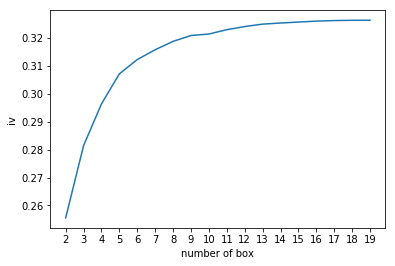

In [81]:
num_bins_ = num_bins.copy()
iv = []
axisx = []

while len(num_bins_) > 2:
    pvs = []
    # 获取num_bins_两两之间卡方检验的置信度
    for i in range(len(num_bins_) -1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0 返回的是卡方值， 1是返回的p值
#         chi2 = scipy.stats.chi2_contingency([x1, x2])[0]
        pv = scipy.stats.chi2_contingency([x1, x2])[1]
        pvs.append(pv)
        
    # 通过p值进行处理 合并p值最大的两组
    i = pvs.index(max(pvs))
    num_bins_[i: i+2] = [(
        num_bins_[i][0], 
        num_bins_[i+1][1],
        num_bins_[i][2] + num_bins_[i+1][2],
        num_bins_[i][3] + num_bins_[i+1][3]
    )]
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    iv.append(get_iv(bins_df))
plt.figure()
plt.plot(axisx, iv)
plt.xticks(axisx)
plt.xlabel('number of box')
plt.ylabel('iv')
plt.show()

In [83]:
# 用最佳分箱个数分箱
def get_bin(num_bins_, n):
    while len(num_bins_) > n:
        pvs = []
        # 获取num_bins_两两之间卡方检验的置信度
        for i in range(len(num_bins_) -1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            # 0 返回的是卡方值， 1是返回的p值
    #         chi2 = scipy.stats.chi2_contingency([x1, x2])[0]
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)

        # 通过p值进行处理 合并p值最大的两组
        i = pvs.index(max(pvs))
        num_bins_[i: i+2] = [(
            num_bins_[i][0], 
            num_bins_[i+1][1],
            num_bins_[i][2] + num_bins_[i+1][2],
            num_bins_[i][3] + num_bins_[i+1][3]
        )]
    return num_bins_

In [84]:
afterbins = get_bin(num_bins_, 4)
afterbins

[(21.0, 58.6873739761368, 62764, 83492),
 (58.6873739761368, 107.0, 34787, 13965)]

In [85]:
bins_df = get_woe(num_bins_)
bins_df

,min,max,count_0,count_1,total,percentage,bad_rate,good%,bad%,woe
0,21.000000,58.687374,62764,83492,146256,0.75,0.570862,0.643397,0.856706,-0.286333
1,58.687374,107.000000,34787,13965,48752,0.25,0.286450,0.356603,0.143294,0.911725


In [94]:
# 将选取最佳分箱个数的过程包装为函数
def graphforbestbin(DF, X, Y, n=5, q=20, graph=True):
    """
    基于卡方检验的分箱
    参数：
    DF：需要输入的数据
    X, 需要分箱的列名
    Y, 分箱数据对应的标签Y列名
    q, 初始分箱的个数
    graph：是否要画出iv图像
    """
    DF = DF[[X, Y]].copy()
    DF['qcut'], bins = pd.qcut(DF[X], retbins=True, q=q, duplicates='drop')
    coount_y0 = DF.loc[DF[Y] == 0].groupby('qcut').count()[Y]
    coount_y1 = DF.loc[DF[Y] == 1].groupby('qcut').count()[Y]
    num_bins = [*zip(bins, bins[1:], coount_y0, coount_y1)]
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(num_bins[0][0], 
                              num_bins[1][1],
                              num_bins[0][2] + num_bins[1][2],
                              num_bins[0][3] + num_bins[1][3]
                             )]
            continue
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0], 
                    num_bins[i][1],
                    num_bins[i-1][2] + num_bins[i][2],
                    num_bins[i-1][3] + num_bins[i][3]
                )]
                break
        else:
            break
    def get_woe(num_bins):
        columns = ['min', 'max', 'count_0', 'count_1']
        df = pd.DataFrame(num_bins, columns=columns)
        df['total'] = df.count_0 + df.count_1
        df['percentage'] = df['total'] / df['total'].sum()
        df['bad_rate'] = df.count_1 / df.total
        df['good%'] = df.count_0 / df.count_0.sum()
        df['bad%'] = df.count_1 / df.count_1.sum()
        df['woe'] = np.log(df['good%']/ df['bad%'])
        return df
    
    def get_iv(df):
        rate = df['good%'] - df['bad%']
        iv = np.sum(rate * df.woe)
        return iv
    
    iv = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        # 获取num_bins_两两之间卡方检验的置信度
        for i in range(len(num_bins) -1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            # 0 返回的是卡方值， 1是返回的p值
    #         chi2 = scipy.stats.chi2_contingency([x1, x2])[0]
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)

        # 通过p值进行处理 合并p值最大的两组
        i = pvs.index(max(pvs))
        num_bins[i: i+2] = [(
            num_bins[i][0], 
            num_bins[i+1][1],
            num_bins[i][2] + num_bins[i+1][2],
            num_bins[i][3] + num_bins[i+1][3]
        )]
        
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        iv.append(get_iv(bins_df))
    
    if graph:
        plt.figure()
        plt.plot(axisx, iv)
        plt.xticks(axisx)
        plt.xlabel('number of box')
        plt.ylabel('iv')
        plt.show()
        
    return bins_df

In [95]:
train_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'qcut'],
      dtype='object')

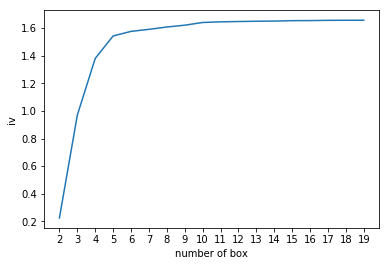

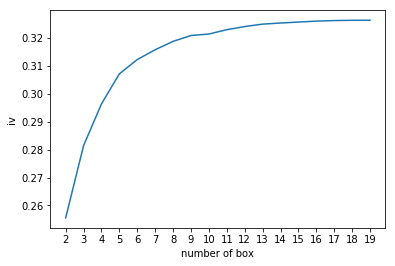

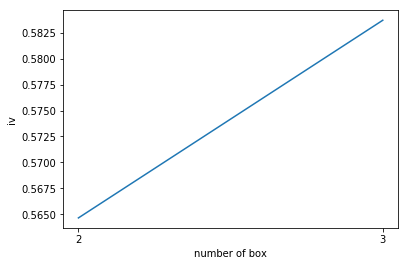

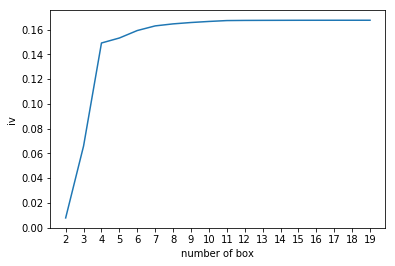

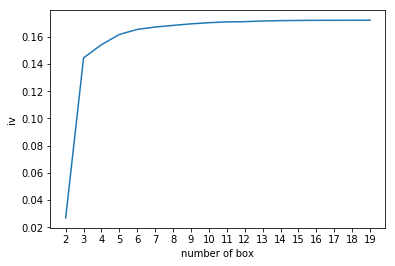

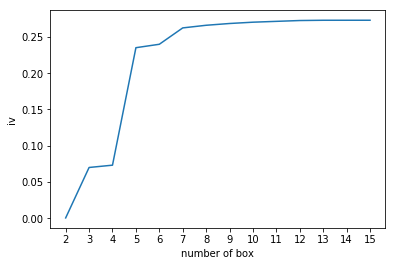

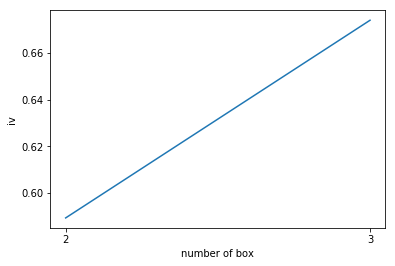

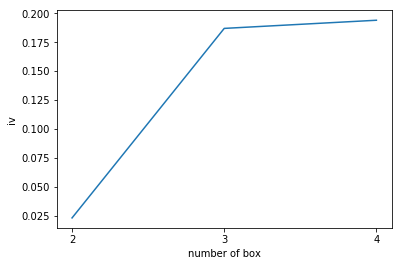

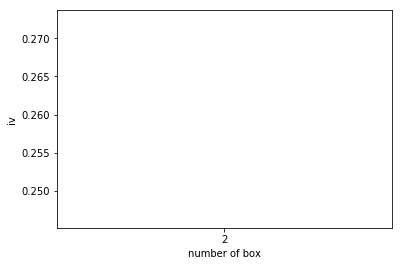

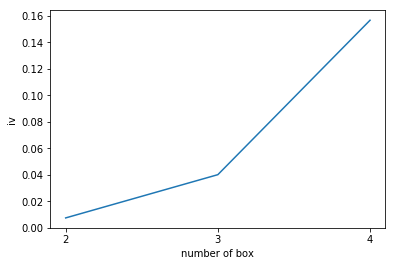

In [96]:
# 对所有的特征进行分箱
for i in train_data.columns[1:-1]:
    graphforbestbin(train_data, i, 'SeriousDlqin2yrs', n=2, q=20)

In [103]:
auto_col_bins = {'RevolvingUtilizationOfUnsecuredLines':6,
                'age':5,
                 'DebtRatio': 4,
                 'MonthlyIncome': 3,
                 'NumberOfOpenCreditLinesAndLoans': 5
                }

# 不能使用自动分箱的变量
hand_bins = {'NumberOfTime30-59DaysPastDueNotWorse': [0, 1, 2, 13],
            'NumberOfTimes90DaysLate': [0, 1, 2, 17],
             'NumberRealEstateLoansOrLines': [0, 1, 2, 4, 54],
             'NumberOfTime60-89DaysPastDueNotWorse': [0, 1, 2, 8],
             'NumberOfDependents': [0, 1, 2, 3]
            }
hand_bins = {k:[-np.inf, *v[:-1], np.inf] for k, v in hand_bins.items()}


In [102]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfDependents': [-inf, 1, 2, inf]}

In [106]:
bins_of_col = {}
# 生成自动分箱的分箱区间和分箱后的iv值
for col in auto_col_bins:  # 这样遍历是遍历字典的key值
    bins_df = graphforbestbin(train_data, 
                              col,
                              'SeriousDlqin2yrs',
                              n=auto_col_bins[col],
                              q=20,
                              graph=False
                             )
    print(bins_df)
    print('*****' * 5)
    bins_list = sorted(set(bins_df['min']).union(bins_df['max']))
    bins_list[0], bins_list[-1] = -np.inf, np.inf
    bins_of_col[col] = bins_list
    print(bins_list)

        min           max  count_0  count_1  total  percentage  bad_rate  \
0  0.000000      0.060553    35886     3116  39002    0.200002  0.079893   
1  0.060553      0.220718    21714     7537  29251    0.149999  0.257666   
2  0.220718      0.551654    18312    20689  39001    0.199997  0.530474   
3  0.551654      0.983145    13900    44602  58502    0.299998  0.762401   
4  0.983145      1.000000     6310    10082  16392    0.084058  0.615056   
5  1.000000  29110.000000     1429    11431  12860    0.065946  0.888880   

      good%      bad%       woe  
0  0.367869  0.031973  2.442833  
1  0.222591  0.077337  1.057169  
2  0.187717  0.212288 -0.123010  
3  0.142490  0.457658 -1.166854  
4  0.064684  0.103451 -0.469580  
5  0.014649  0.117293 -2.080318  
*************************
[-inf, 0.060552531400000005, 0.2207179143, 0.5516541889036061, 0.9831449087861944, 0.9999998999999999, inf]
         min         max  count_0  count_1  total  percentage  bad_rate  \
0  21.000000   48.50

In [107]:
# 合并数据
bins_of_col.update(hand_bins)
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.060552531400000005,
  0.2207179143,
  0.5516541889036061,
  0.9831449087861944,
  0.9999998999999999,
  inf],
 'age': [-inf, 48.503543347020816, 58.6873739761368, 64.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01842646531658421,
  0.4026974551909623,
  1.4848397764291053,
  inf],
 'MonthlyIncome': [-inf, 0.10371906020472159, 5600.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf,
  5.9733394550272125,
  6.0,
  8.895242655984902,
  9.107901577947791,
  inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [109]:
# 计算各箱的woe并映射到数据中
data = train_data.copy()

data = data[['age', 'SeriousDlqin2yrs']].copy()
data['cut'] = pd.cut(data['age'], [-np.inf, 48.503543347020816, 58.6873739761368, 64.0, 74.0, np.inf])
data.head()

,age,SeriousDlqin2yrs,cut
0,53.000000,0,"(48.504, 58.687]"
1,44.543111,1,"(-inf, 48.504]"
2,69.000000,0,"(64.0, 74.0]"
3,32.620861,1,"(-inf, 48.504]"
4,43.000000,1,"(-inf, 48.504]"


In [111]:
data.groupby('cut')['SeriousDlqin2yrs'].value_counts()

cut               SeriousDlqin2yrs
(-inf, 48.504]    1                   58051
                  0                   39453
(48.504, 58.687]  1                   25441
                  0                   23311
(58.687, 64.0]    0                   13647
                  1                    7714
(64.0, 74.0]      0                   13381
                  1                    4740
(74.0, inf]       0                    7759
                  1                    1511
Name: SeriousDlqin2yrs, dtype: int64

In [112]:
# 使用unstack将树状结构变成表结构
data.groupby('cut')['SeriousDlqin2yrs'].value_counts().unstack()

SeriousDlqin2yrs,0,1
cut,,
"(-inf, 48.504]",39453,58051
"(48.504, 58.687]",23311,25441
"(58.687, 64.0]",13647,7714
"(64.0, 74.0]",13381,4740
"(74.0, inf]",7759,1511


In [113]:
bins_df = data.groupby('cut')['SeriousDlqin2yrs'].value_counts().unstack()
bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 48.504]",39453,58051,-0.387176
"(48.504, 58.687]",23311,25441,-0.088401
"(58.687, 64.0]",13647,7714,0.569519
"(64.0, 74.0]",13381,4740,1.036835
"(74.0, inf]",7759,1511,1.635118


In [114]:
# 将以上的过程包装成函数
def get_woe(df, col, y, bins):
    df = df[[col, y]].copy()
    df['cut'] = pd.cut(df[col], bins)
    bins_df = df.groupby('cut')[y].value_counts().unstack()
    woe = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe


In [115]:
# 计算所有特征的woe值
woe_all = {}
for col in bins_of_col:
    woe_all[col] = get_woe(train_data, col, 'SeriousDlqin2yrs', bins_of_col[col])
woe_all

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0606]     2.442833
 (0.0606, 0.221]    1.057169
 (0.221, 0.552]    -0.123010
 (0.552, 0.983]    -1.166854
 (0.983, 1.0]      -0.469580
 (1.0, inf]        -2.080318
 dtype: float64, 'age': cut
 (-inf, 48.504]     -0.387176
 (48.504, 58.687]   -0.088401
 (58.687, 64.0]      0.569519
 (64.0, 74.0]        1.036835
 (74.0, inf]         1.635118
 dtype: float64, 'DebtRatio': cut
 (-inf, 0.0184]     1.506501
 (0.0184, 0.403]    0.040362
 (0.403, 1.485]    -0.395103
 (1.485, inf]       0.176310
 dtype: float64, 'MonthlyIncome': cut
 (-inf, 0.104]      1.487275
 (0.104, 5600.0]   -0.235481
 (5600.0, inf]      0.224811
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 5.973]    -0.281787
 (5.973, 6.0]      1.769811
 (6.0, 8.895]     -0.208129
 (8.895, 9.108]    1.188047
 (9.108, inf]      0.025029
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    1.092233
 (0.0, 1.0]    -1.389473
 (1.0, 2.0]    -2.036

In [116]:
# 把所有的woe值映射到原始数据中
train_data_woe = pd.DataFrame(index=train_data.index)
train_data_woe['age'] = pd.cut(train_data['age'], bins_of_col['age']).map(woe_all['age'])
train_data_woe['age']

0        -0.088401
1        -0.387176
2         1.036835
3        -0.387176
4        -0.387176
5        -0.387176
6         1.635118
7        -0.387176
8        -0.088401
9        -0.387176
10        1.036835
11       -0.088401
12       -0.387176
13       -0.387176
14       -0.088401
15       -0.088401
16        1.635118
17       -0.387176
18        1.635118
19       -0.088401
20       -0.387176
21       -0.088401
22        0.569519
23       -0.088401
24       -0.088401
25       -0.387176
26       -0.387176
27       -0.387176
28       -0.387176
29       -0.088401
            ...   
194978   -0.387176
194979   -0.088401
194980   -0.387176
194981   -0.387176
194982    0.569519
194983   -0.387176
194984    0.569519
194985   -0.387176
194986   -0.387176
194987   -0.387176
194988   -0.387176
194989    0.569519
194990    1.036835
194991    0.569519
194992   -0.387176
194993    1.036835
194994   -0.387176
194995   -0.387176
194996   -0.387176
194997    1.036835
194998   -0.088401
194999   -0.

In [118]:
# 接下来把所有的特征数据映射过去
for col in bins_of_col:
    train_data_woe[col] = pd.cut(train_data[col], bins_of_col[col]).map(woe_all[col])
train_data_woe['SeriousDlqin2yrs'] = train_data['SeriousDlqin2yrs']
train_data_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.088401,2.442833,0.176310,-0.235481,0.025029,1.092233,0.691197,-0.006077,0.542996,0.625341,0
1,-0.387176,-0.123010,0.040362,0.224811,-0.281787,-1.389473,0.691197,-0.108496,-2.468678,-0.545073,1
2,1.036835,2.442833,0.040362,-0.235481,1.188047,1.092233,0.691197,-0.006077,0.542996,-0.579585,0
3,-0.387176,-0.123010,-0.395103,-0.235481,0.025029,-2.036632,0.691197,-0.108496,0.542996,-0.545073,1
4,-0.387176,-0.123010,-0.395103,0.224811,-0.208129,1.092233,0.691197,-0.422143,0.542996,-0.474213,1


In [121]:
# 同样的方式处理测试数据集
test_data_woe = pd.DataFrame(index=test_data.index)
for col in bins_of_col:
    test_data_woe[col] = pd.cut(test_data[col], bins_of_col[col]).map(woe_all[col])
test_data_woe['SeriousDlqin2yrs'] = test_data['SeriousDlqin2yrs']

test_x = test_data_woe.iloc[:, :-1]
test_y = test_data_woe.iloc[:, -1]

In [122]:
train_x = train_data_woe.iloc[:, :-1]
train_y = train_data_woe.iloc[:, -1]

model = linear_model.LogisticRegression().fit(train_x, train_y)
model.score(test_x, test_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8613956159663061

0.8658362733836561 0.21842105263157896


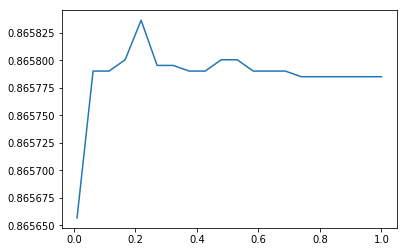

In [129]:
# 接下来开始调参
c_1 = np.linspace(0.01, 1, 20)
c_list = list(c_1)
score = []
for i in c_1:
    lr = linear_model.LogisticRegression(solver='liblinear', C=i).fit(train_x, train_y)
    score.append(lr.score(train_x, train_y))
plt.plot(c_1, score)
print(max(score), c_list[score.index(max(score))])
plt.show()

0.8658362733836561 0.21578947368421053


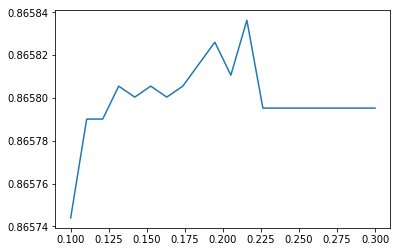

In [130]:
# 接下来开始微调
c_1 = np.linspace(0.1, 0.3, 20)
c_list = list(c_1)
score = []
for i in c_1:
    lr = linear_model.LogisticRegression(solver='liblinear', C=i).fit(train_x, train_y)
    score.append(lr.score(train_x, train_y))
plt.plot(c_1, score)
print(max(score), c_list[score.index(max(score))])
plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8658362733836561 6


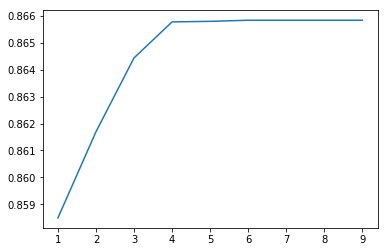

In [131]:
# 接下来开始调
iters = list(range(1, 10))
score = []
for i in iters:
    lr = linear_model.LogisticRegression(solver='liblinear', C=0.21578947368421053, max_iter=i).fit(train_x, train_y)
    score.append(lr.score(train_x, train_y))
plt.plot(iters, score)
print(max(score), iters[score.index(max(score))])
plt.show()

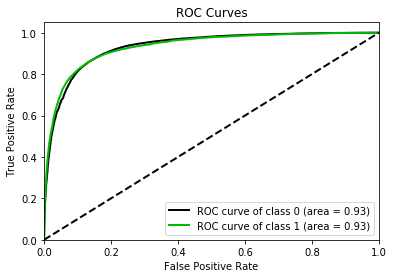

In [137]:
# 从准确率上来说一般 我们来看看roc曲线
import scikitplot as skplt

test_proba_df = pd.DataFrame(lr.predict_proba(test_x))
skplt.metrics.plot_roc(test_y, test_proba_df, plot_micro=False, plot_macro=False)

In [ ]:
# 制作评分卡
